# Imports and Data

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import phonecalls as pc
import scipy.stats as stats
import scipy.interpolate as interpol
import statsmodels.api as sm
import pymannkendall as mk
import time
import copy
import math
import pickle


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

with open('unfiltered.pkl', 'rb') as handle:
    unfiltered = pickle.load(handle)
handle.close()

with open('../itdata/mtl_unfiltered.pickle', 'rb') as handle:
    tmpunf = pickle.load(handle)
    handle.close()
    
unfiltered.update(tmpunf)

with open('../itdata/mtl_dffa15.pickle', 'rb') as handle:
    itdffa15 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_dffa30.pickle', 'rb') as handle:
    itdffa30 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_livesd.pickle', 'rb') as handle:
    itlives = pickle.load(handle)
    handle.close()
    
unfiltered['mit'] = pc.allcalls('../usadata/CallLog.csv', ('type', 'outgoing', 'outgoing+', 'missed'), 'participantID.A', 'number.hash', 
                                ['local_time'], "%Y-%m-%d %H:%M:%S", header=True, min_activity=1)
unfiltered['uk12'] = pd.DataFrame()
for c in ['uk1', 'uk2']:
    df = unfiltered[c].copy(deep=True)
    df['ego'] = df['ego'].map(lambda i: f'{dict({"uk1": "a", "uk2": "b"})[c]}{i}')
    unfiltered['uk12'] = unfiltered['uk12'].append(df)

L = {'uk': 300, 'uk1': 300, 'uk2': 270, 'it': 365, 'itb': 365, 'mit': 220}
calls = {}
for c in ['uk', 'uk1', 'uk2', 'it', 'mit']:
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lf = df.groupby('ea')[['aclock']].max()
    keep = lf.loc[lf['aclock'] <= L[c]]
    df = df[df['ea'].isin(keep.index)]
    calls[c] = pc.apply_filters(df, 60)
calls['uk12'] = pd.DataFrame()
for c in ['uk1', 'uk2']:
    df = calls[c].copy(deep=True)
    df['ego'] = df['ego'].map(lambda i: f'{dict({"uk1": "a", "uk2": "b"})[c]}{i}')
    calls['uk12'] = calls['uk12'].append(df)
    
    
globalt0 = dt.datetime.now()

In [2]:
for c in ['it', 'mit']:
    # No Filter
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    print(c, len(df['ea'].unique()))
    # L
    lf = df.groupby('ea')[['aclock']].max()
    keep = lf.loc[lf['aclock'] <= L[c]]
    df = df[df['ea'].isin(keep.index)]
    print(c, len(df['ea'].unique()))
    # ncalls = df.groupby('ea')[['time']].count()
    # keep = ncalls.loc[ncalls['time'] >= 3]
    # df = df[df['ea'].isin(keep.index)]
    # calls[{'it': 'itL', 'mit': 'mitL'}[c]] = df
    # print(c, len(df['ea'].unique()))
    # Delta t to the left (by ego)
    t0i = df.groupby('ego')['uclock'].min()
    t0x = df.groupby('ea')[['uclock']].min()
    t0x['dif'] = t0x.index.map(lambda i: t0x.at[i, 'uclock'] - t0i[i[0]])
    keep = t0x.loc[t0x['dif'] > 50]
    df = df[df['ea'].isin(keep.index)]
    print(len(df['ea'].unique()))
    # Delta t to the right
    df = pc.apply_filters(df, 60)
    df['ea'] = list(zip(df['ego'], df['alter']))
    calls[{'it': 'itb', 'mit': 'mitb'}[c]] = df

it 23674
it 21064
17501
mit 4145
mit 4063
2666


#  Obtain cumulative of $f_{ix}$

In [3]:
limits = {}
for c in ['uk2', 'itb', 'it', 'mit']:
    limits[c] = []
    limits[c].append((0, 50))
    limits[c].append((L[c] // 2 - 25, L[c]//2 + 25))
    limits[c].append((L[c] - 50, L[c]))
limits

{'uk2': [(0, 50), (110, 160), (220, 270)],
 'itb': [(0, 50), (157, 207), (315, 365)],
 'it': [(0, 50), (157, 207), (315, 365)],
 'mit': [(0, 50), (85, 135), (170, 220)]}

In [4]:
test = calls['uk2'].copy(deep=True)
test.head()

,ego,alter,time,uclock,aclock
0,C07779270485,C01132304499,2007-09-26 08:42:00,24,0
1,C07779270485,C01132304499,2007-10-05 14:32:00,33,9
2,C07779270485,C01132304499,2007-10-27 01:11:00,55,31
3,C07779270485,C01132304499,2008-01-09 20:35:00,130,106
4,C07779270485,C01132416800,2008-05-06 02:16:00,247,0


In [5]:
test['ea'] = list(zip(test['ego'], test['alter']))
test.head()

,ego,alter,time,uclock,aclock,ea
0,C07779270485,C01132304499,2007-09-26 08:42:00,24,0,"(C07779270485, C01132304499)"
1,C07779270485,C01132304499,2007-10-05 14:32:00,33,9,"(C07779270485, C01132304499)"
2,C07779270485,C01132304499,2007-10-27 01:11:00,55,31,"(C07779270485, C01132304499)"
3,C07779270485,C01132304499,2008-01-09 20:35:00,130,106,"(C07779270485, C01132304499)"
4,C07779270485,C01132416800,2008-05-06 02:16:00,247,0,"(C07779270485, C01132416800)"


In [6]:
nix = test.groupby('ea')[['time']].count()
nix = nix.loc[nix['time'] >= 10]
allties = list(nix.index)

In [7]:
subtest = test.loc[test['ea'] == allties[30]]
subtest.head()

,ego,alter,time,uclock,aclock,ea
1068,C07792658311,C01865777333,2007-10-19 14:39:00,47,0,"(C07792658311, C01865777333)"
1069,C07792658311,C01865777333,2007-10-21 19:21:00,50,3,"(C07792658311, C01865777333)"
1070,C07792658311,C01865777333,2008-01-24 19:02:00,145,98,"(C07792658311, C01865777333)"
1071,C07792658311,C01865777333,2008-01-24 20:13:00,145,98,"(C07792658311, C01865777333)"
1072,C07792658311,C01865777333,2008-01-26 09:52:00,146,99,"(C07792658311, C01865777333)"


In [8]:
subtest2 = subtest.groupby('aclock')[['time']].count()

In [9]:
subtest2['cumulative'] = subtest2['time'].cumsum()
subtest2.head()

,time,cumulative
aclock,,
0,1,1
3,1,2
98,2,4
99,1,5
228,1,6


In [10]:
subtest2['cmf'] = subtest2['cumulative'].div(sum(subtest2['time']))
subtest2.head()

,time,cumulative,cmf
aclock,,,
0,1,1,0.083333
3,1,2,0.166667
98,2,4,0.333333
99,1,5,0.416667
228,1,6,0.500000


In [11]:
X = list(subtest2.index)
Y = list(subtest2['cmf'])
X = sm.add_constant(X)

In [12]:
fitted = sm.OLS(Y, X).fit()
fitted.summary()

/home/vsvh/.local/lib/python3.10/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     26.76
Date:                Wed, 09 Mar 2022   Prob (F-statistic):            0.00207
Time:                        22:47:49   Log-Likelihood:                 5.1353
No. Observations:                   8   AIC:                            -6.271
Df Residuals:                       6   BIC:                            -6.112
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1102      0.092      1.203      0.274      -0.114       0.334
x1             0.0028      0.001      5.173      0.002       0.001       0.004
==============================================================================
Omnibus:                        0.968   Durbin-Watson:                   1.310
Prob(Omnibus):                  0.616   Jarque-Bera (JB):                0.019
Skew:                          -0.118   Prob(JB):                        0.990
Kurtosis:                       2.947   Cond. No.                         301.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
subtest3 = pc.get_fal(subtest, 0, 500, 15)

In [14]:
fitted.rsquared

0.8168431274905407

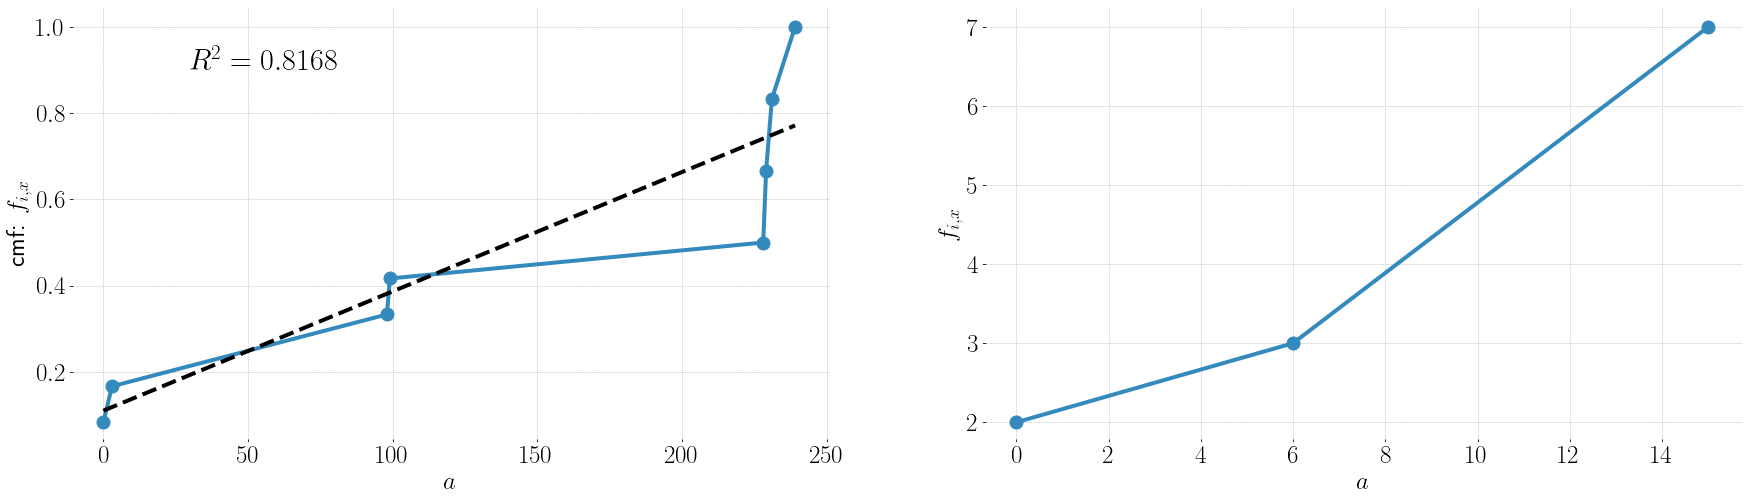

In [15]:
plt.figure(figsize=(30, 8))

plt.subplot(121)
plt.xlabel(r"$a$")
plt.ylabel(r"cmf: $f_{i,x}$")
plt.plot(subtest2.index, subtest2['cmf'], marker=markers[0], markersize=13, ls='solid', lw=4)
plt.plot(subtest2.index, [fitted.params[0] + fitted.params[1] * x for x in subtest2.index], marker="", ls="dashed", c="black", lw=4)
plt.annotate(fr"$R^{{2}} = {fitted.rsquared:.4f}$", (30, 0.9), fontsize=30)

plt.subplot(122)
plt.xlabel(r"$a$")
plt.ylabel(r"$f_{i,x}$")
plt.plot(subtest3['f'].index, subtest3['f']['f'], marker=markers[0], markersize=13, ls='solid', lw=4)

## Multiple ties

In [24]:
ncalls = test.groupby('ea')[['time']].count()
ncalls = ncalls.sort_values(by='time', ascending=False)
ncalls.head()

,time
ea,
"(C07800650314, C27727579975)",532
"(C07817280467, C07975653749)",436
"(C07814508939, C07769801666)",355
"(C07800643466, C07768712580)",350
"(C07800643466, C07967999632)",325


In [25]:
alter_sample = list(ncalls.index)[:10]
len(alter_sample)

10

In [26]:
cumuanalysis = {}
for tie in alter_sample:
    cumuanalysis[tie] = {}
    subtest = test.loc[test['ea'] == tie]
    subtest2 = subtest.groupby('aclock')[['time']].count()
    subtest2['cumulative'] = subtest2['time'].cumsum()
    subtest2['cmf'] = subtest2['cumulative'].div(sum(subtest2['time']))
    df = subtest2[['cmf']]
    cumuanalysis[tie]['cmf'] = df
    X = list(subtest2.index)
    Y = list(subtest2['cmf'])
    X = sm.add_constant(X)
    fitted = sm.OLS(Y, X).fit()
    cumuanalysis[tie]['fitted'] = pd.DataFrame({'X': df.index, 'Y': [fitted.params[0] + fitted.params[1] * x for x in df.index]})
    cumuanalysis[tie]['rsq'] = fitted.rsquared
    subtest3 = pc.get_fal(subtest, 0, 500, 30)
    cumuanalysis[tie]['fix'] = subtest3['f'].copy()

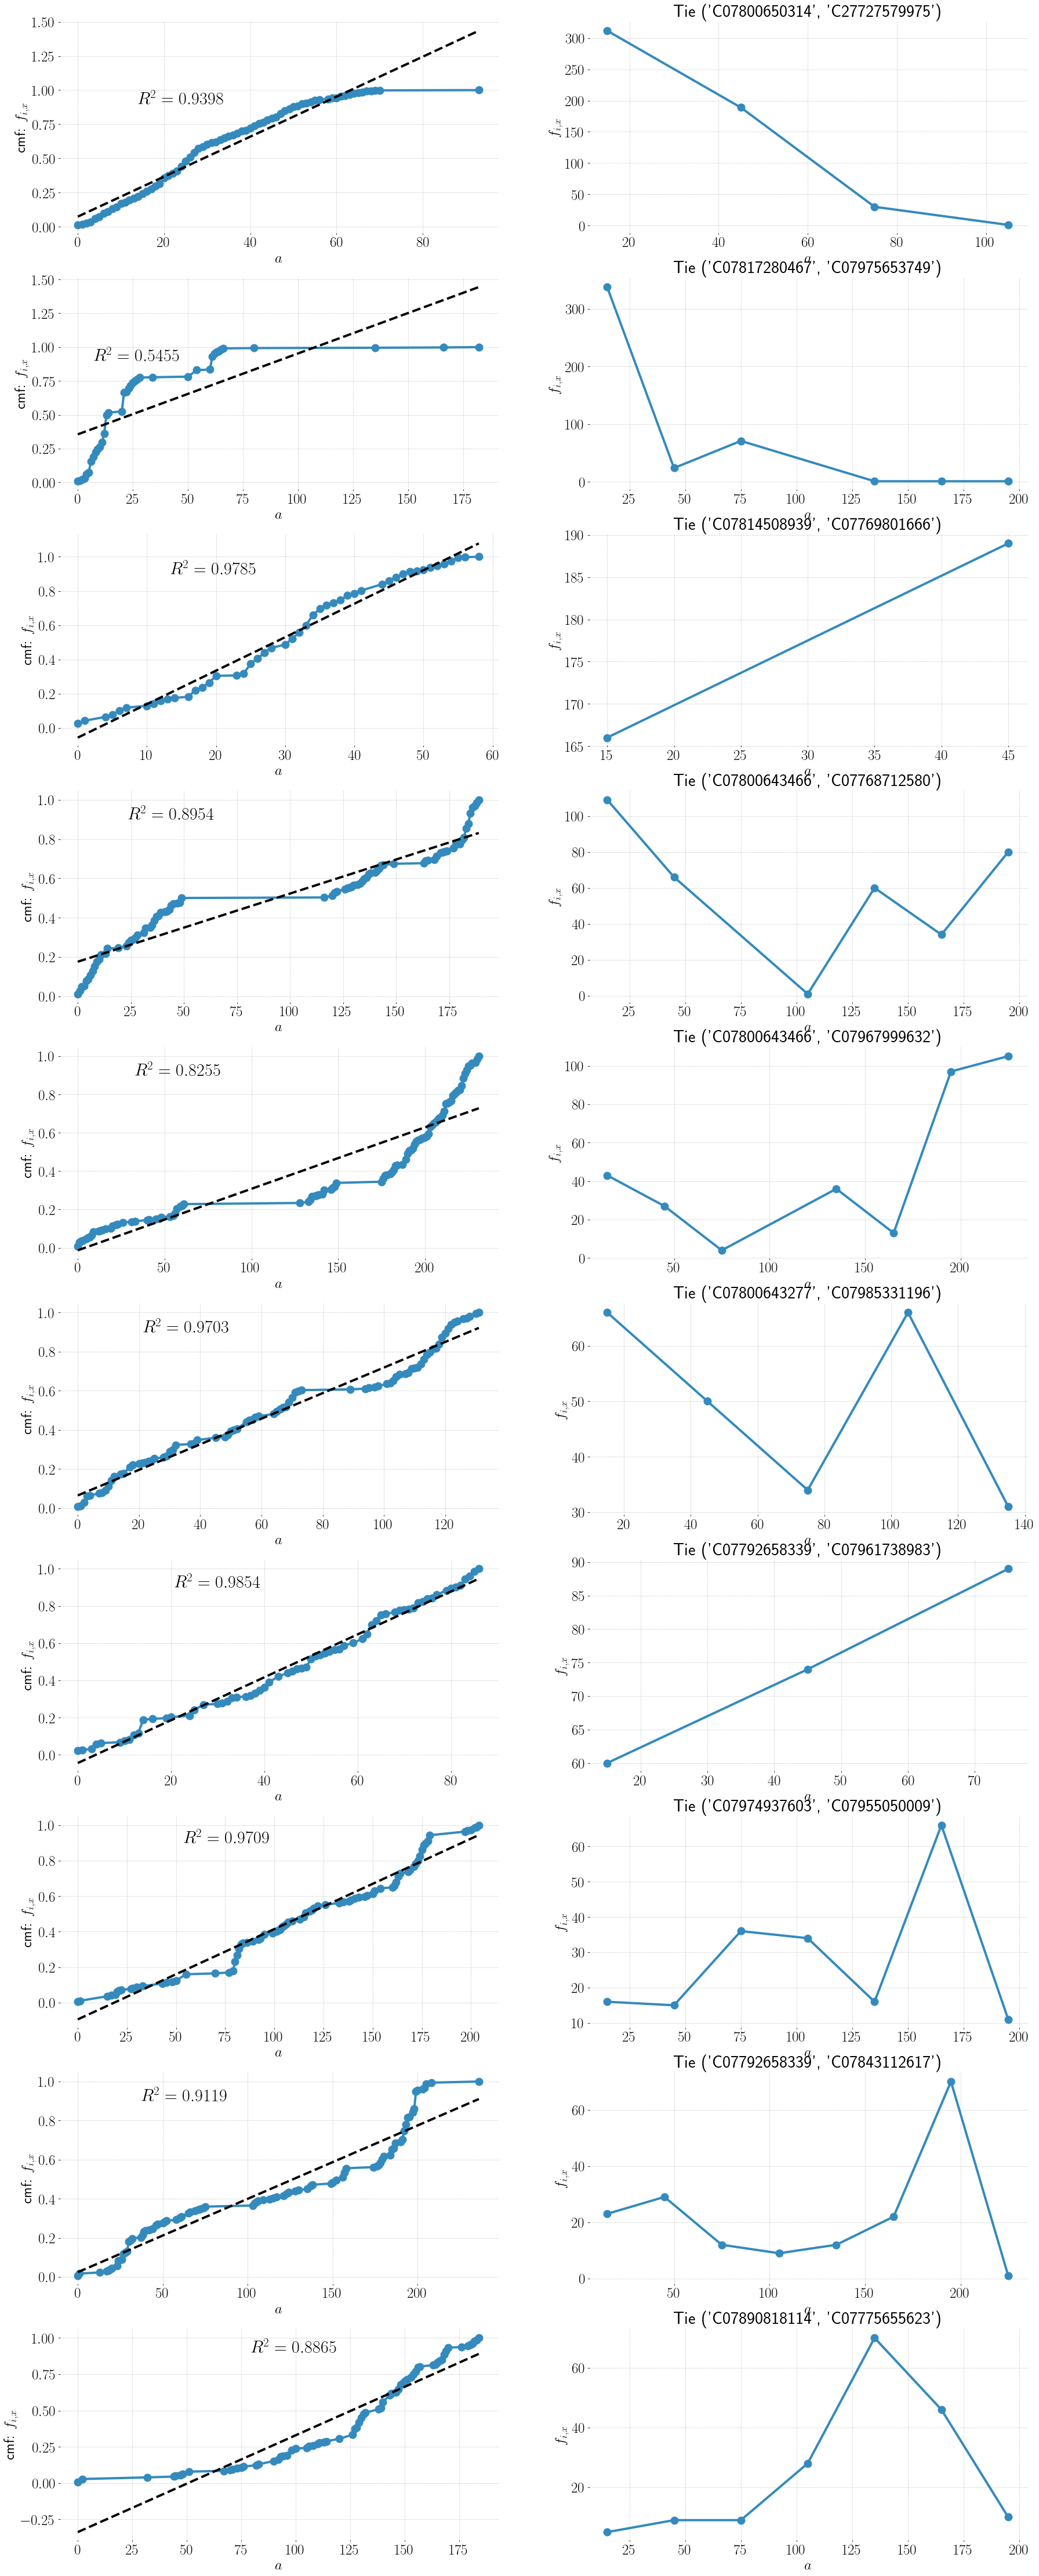

In [27]:
nr = len(cumuanalysis.keys())
nc = 2
plt.figure(figsize=(15*nc, 8*nr))
p = 1
for tie in cumuanalysis.keys():
    plt.subplot(nr, nc, p)
    plt.xlabel(r"$a$")
    plt.ylabel(r"cmf: $f_{i,x}$")
    plt.plot(cumuanalysis[tie]['cmf'].index, cumuanalysis[tie]['cmf']['cmf'], marker=markers[0], markersize=13, ls='solid', lw=4)
    plt.plot(cumuanalysis[tie]['fitted']['X'], cumuanalysis[tie]['fitted']['Y'], marker="", ls="dashed", c="black", lw=4)
    plt.annotate(fr"$R^{{2}} = {cumuanalysis[tie]['rsq']:.4f}$", (np.percentile(cumuanalysis[tie]['cmf'].index, 20), 0.9), fontsize=30)
    p += 1
    
    plt.subplot(nr, nc, p)
    plt.title(f"Tie {tie}")
    plt.xlabel(r"$a$")
    plt.ylabel(r"$f_{i,x}$")
    plt.plot([(x * 30) + 15 for x in cumuanalysis[tie]['fix'].index], cumuanalysis[tie]['fix']['f'], marker=markers[0], markersize=13, ls='solid', lw=4)
    p += 1